In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs

from anemoi.datasets.grids import cutout_mask
from anemoi.datasets import open_dataset

In [2]:
plt.style.use("~/nice.mplstyle")

In [3]:
def open_nested(trim_edge=0, min_distance_km=0):
    
    data_dir = "/pscratch/sd/t/timothys/nested-eagle/0.25deg-06km/data"
    return open_dataset(
        cutout=[
            {
                "dataset": f"{data_dir}/hrrr.zarr",
                "trim_edge": trim_edge,
            },
            f"{data_dir}/gfs.zarr",
        ],
        adjust="all",
        min_distance_km=min_distance_km,
    )

In [4]:
data = open_nested(trim_edge=(25, 26, 25, 26), min_distance_km=0)
n_cutout = data.grids[0]

Dataset /pscratch/sd/t/timothys/nested-eagle/0.25deg-06km/data/hrrr.zarr has missing dates
Dataset /pscratch/sd/t/timothys/nested-eagle/0.25deg-06km/data/gfs.zarr has missing dates


In [5]:
hmesh = xr.load_dataset("latentx2.stage1.spongex1.hrrr06km.trim25-26.nc")
hmesh2 = xr.load_dataset("latentx4.stage2.spongex1.hrrr06km.trim25-26.nc")
gmesh = xr.load_dataset("../global-2stage/latent.stage1.global_quarter_degree.unsorted.nc")
gmesh2 = xr.load_dataset("../global-2stage/latent.stage2.global_quarter_degree.unsorted.nc")

In [7]:
glon, glat = np.meshgrid(gmesh.lon, gmesh.lat)
glon2, glat2 = np.meshgrid(gmesh2.lon, gmesh2.lat)

In [8]:
mask = cutout_mask(
        lats=hmesh.lat.values.flatten(),
        lons=hmesh.lon.values.flatten(),
        global_lats=glat.flatten(),
        global_lons=glon.flatten(),
        min_distance_km=0,
)

mask2 = cutout_mask(
        lats=hmesh2.lat.values.flatten(),
        lons=hmesh2.lon.values.flatten(),
        global_lats=glat2.flatten(),
        global_lons=glon2.flatten(),
        min_distance_km=0,
)

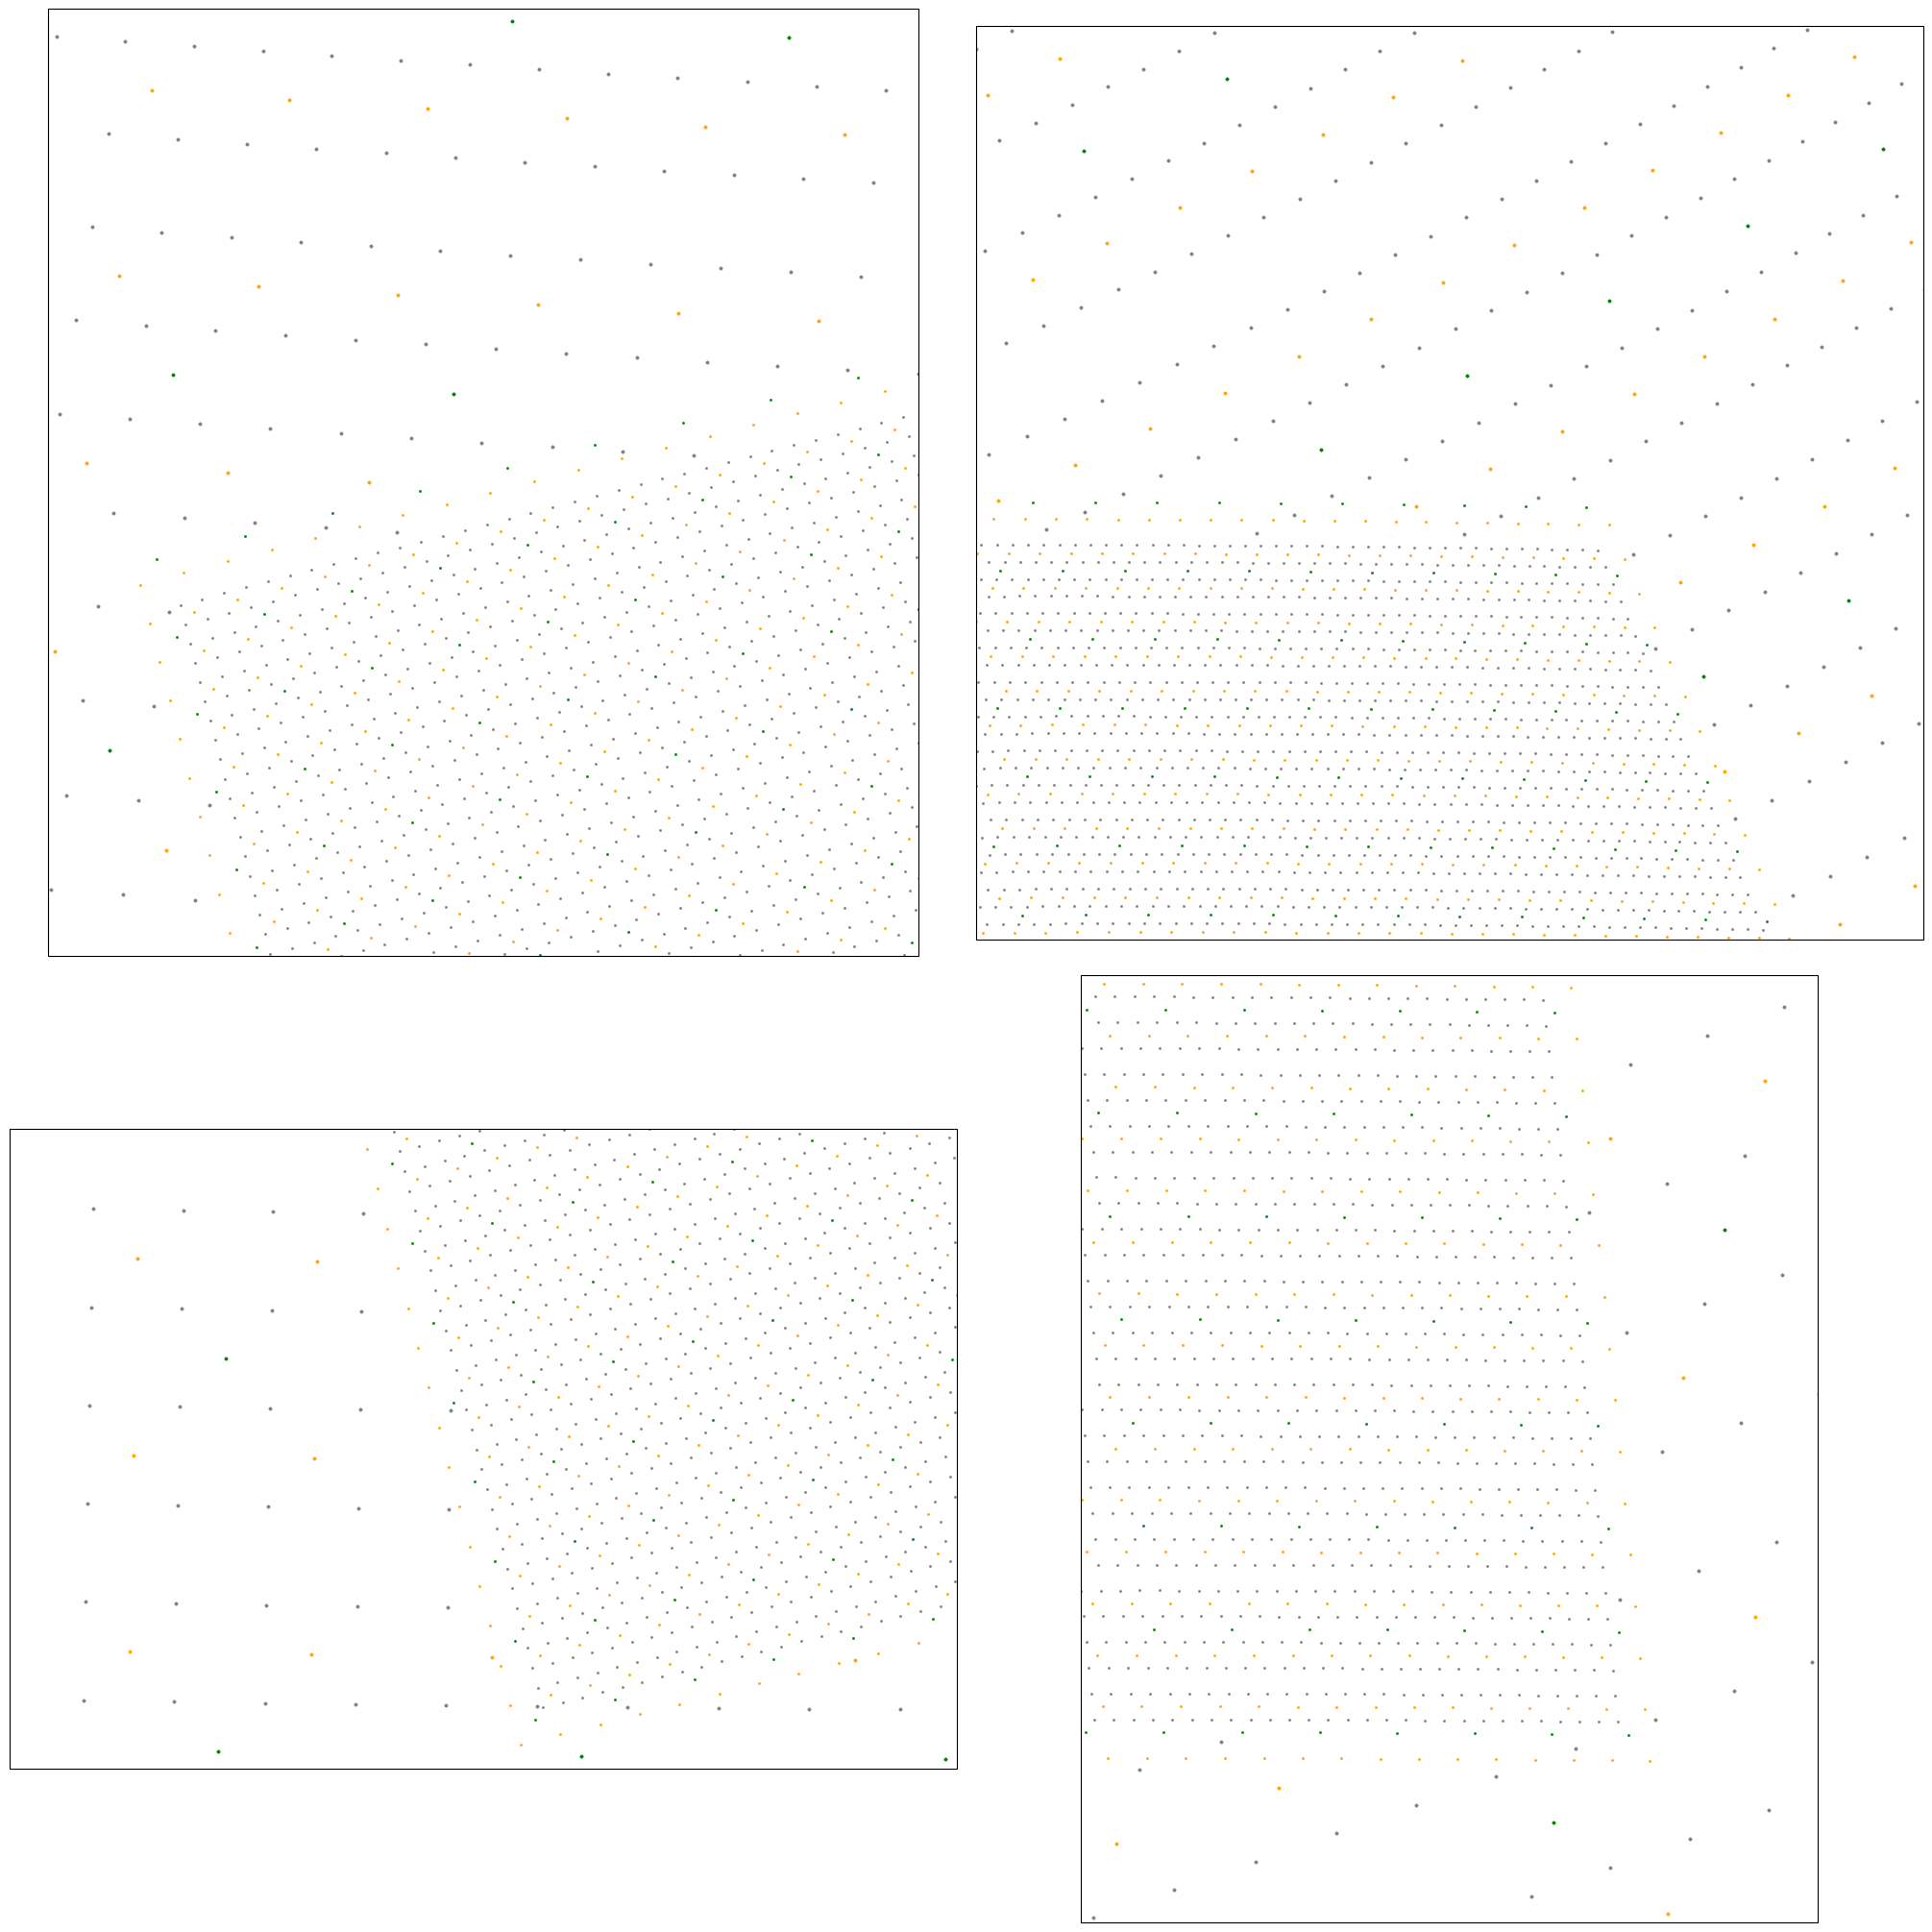

In [18]:
fig, axs = plt.subplots(
    2, 2,
    figsize=(20,20),
    subplot_kw={"projection": ccrs.Orthographic(central_longitude=-120, central_latitude=20)},
)

for x,y, x2, y2, x_d, y_d, s in zip(
    [glon.flatten()[mask], hmesh.lon.values.flatten()],
    [glat.flatten()[mask], hmesh.lat.values.flatten()],
    [glon2.flatten()[mask2], hmesh2.lon.values.flatten()],
    [glat2.flatten()[mask2], hmesh2.lat.values.flatten()],
    [data.longitudes[n_cutout:], data.longitudes[:n_cutout]],
    [data.latitudes[n_cutout:], data.latitudes[:n_cutout]],
    [6, 3],
):

    kw = {"transform": ccrs.PlateCarree(), "s": s}
    for ax in axs.flatten():
        ax.scatter(x,y, color="orange", **kw)
        ax.scatter(x2,y2, color="green", **kw)
        ax.scatter(x_d, y_d, color="gray", **kw)
# The overview
#axs[0].set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())
#axs[1].set_extent([-125, -115, 20, 30], crs=ccrs.PlateCarree())

axs[0, 0].set_extent([228.25, 230.85, 46.2, 48.6], crs=ccrs.PlateCarree())
axs[0, 1].set_extent([294.6, 297.2, 46.2, 48.6], crs=ccrs.PlateCarree())
axs[1, 0].set_extent([236.8, 239.4, 22.6, 24.2], crs=ccrs.PlateCarree())
axs[1, 1].set_extent([285.6, 287.2, 22.6, 24.2], crs=ccrs.PlateCarree())
#fig.savefig(f"mesh_and_data_nodes.jpeg", bbox_inches="tight", dpi=300)

Sort stuff out

In [19]:
clon = np.concatenate([glon.flatten()[mask], hmesh.lon.values.flatten()])
clat = np.concatenate([glat.flatten()[mask], hmesh.lat.values.flatten()])

In [20]:
clon2 = np.concatenate([glon2.flatten()[mask2], hmesh2.lon.values.flatten()])
clat2 = np.concatenate([glat2.flatten()[mask2], hmesh2.lat.values.flatten()])

In [33]:
print(glon.flatten()[mask].max(), glon.flatten()[mask].min())
print(glat.flatten()[mask].max(), glat.flatten()[mask].min())

359.625 0.125
89.875 -89.625


In [21]:
print(glon2.flatten()[mask2].max(), glon2.flatten()[mask2].min())
print(glat2.flatten()[mask2].max(), glat2.flatten()[mask2].min())

359.375 0.375
89.625 -89.375


In [22]:
print(hmesh.lon.values.max(), hmesh.lon.values.min())
print(hmesh.lat.values.max(), hmesh.lat.values.min())

296.4925113601296 228.38401918215231
51.29340234675392 22.652569981357125


In [23]:
print(hmesh2.lon.values.max(), hmesh2.lon.values.min())
print(hmesh2.lat.values.max(), hmesh2.lat.values.min())

296.44768856714416 228.428682614415
51.34590517167105 22.716381904349717


In [25]:
from anemoi.graphs.generate.utils import get_coordinates_ordering
# Lets not worry about radians? since lon is 0-360 in both and -90-90 in both
#from anemoi.graphs.generate.transforms import cartesian_to_latlon_rad

In [26]:
coords = np.stack([clon, clat], axis=-1)
order = get_coordinates_ordering(coords)

In [27]:
coords2 = np.stack([clon2, clat2], axis=-1)
order2 = get_coordinates_ordering(coords2)

In [28]:
order

array([ 76061, 129383, 130103, ..., 210744, 194904, 158184],
      shape=(355890,))

In [29]:
order2

array([16758,  9719, 34145, ..., 58266, 38826, 57906], shape=(89079,))

In [30]:
coords[:,0].min()

np.float64(0.125)

In [31]:
(coords[order] == coords[order,:]).all()

np.True_

In [34]:
cds = xr.Dataset(
    attrs={"n_cutout": n_cutout}
)

cds["lon"] = xr.DataArray(
    coords[order, 0],
    coords={"lon": coords[order, 0]},
)

cds["lat"] = xr.DataArray(
    coords[order, 1],
    coords={"lat": coords[order,1]},
)

In [35]:
cds

<xarray.Dataset> Size: 6MB
Dimensions:  (lon: 355890, lat: 355890)
Coordinates:
  * lon      (lon) float64 3MB 359.6 359.6 359.6 359.6 ... 0.125 0.125 0.125
  * lat      (lat) float64 3MB 34.88 -3.625 -4.125 ... -60.62 -49.62 -24.12
Data variables:
    *empty*
Attributes:
    n_cutout:  405344

In [36]:
cds2 = xr.Dataset(
    attrs={"n_cutout": n_cutout}
)

cds2["lon"] = xr.DataArray(
    coords2[order2, 0],
    coords={"lon": coords2[order2, 0]},
)

cds2["lat"] = xr.DataArray(
    coords2[order2, 1],
    coords={"lat": coords2[order2,1]},
)

In [37]:
cds2

<xarray.Dataset> Size: 1MB
Dimensions:  (lon: 89079, lat: 89079)
Coordinates:
  * lon      (lon) float64 713kB 359.4 359.4 359.4 359.4 ... 0.375 0.375 0.375
  * lat      (lat) float64 713kB 42.62 63.62 -8.375 ... -76.38 -22.38 -75.38
Data variables:
    *empty*
Attributes:
    n_cutout:  405344

In [8]:
89079 / 32414

2.748164373418893

In [10]:
4320 * 3

12960

In [11]:
89079 / 12960

6.873379629629629

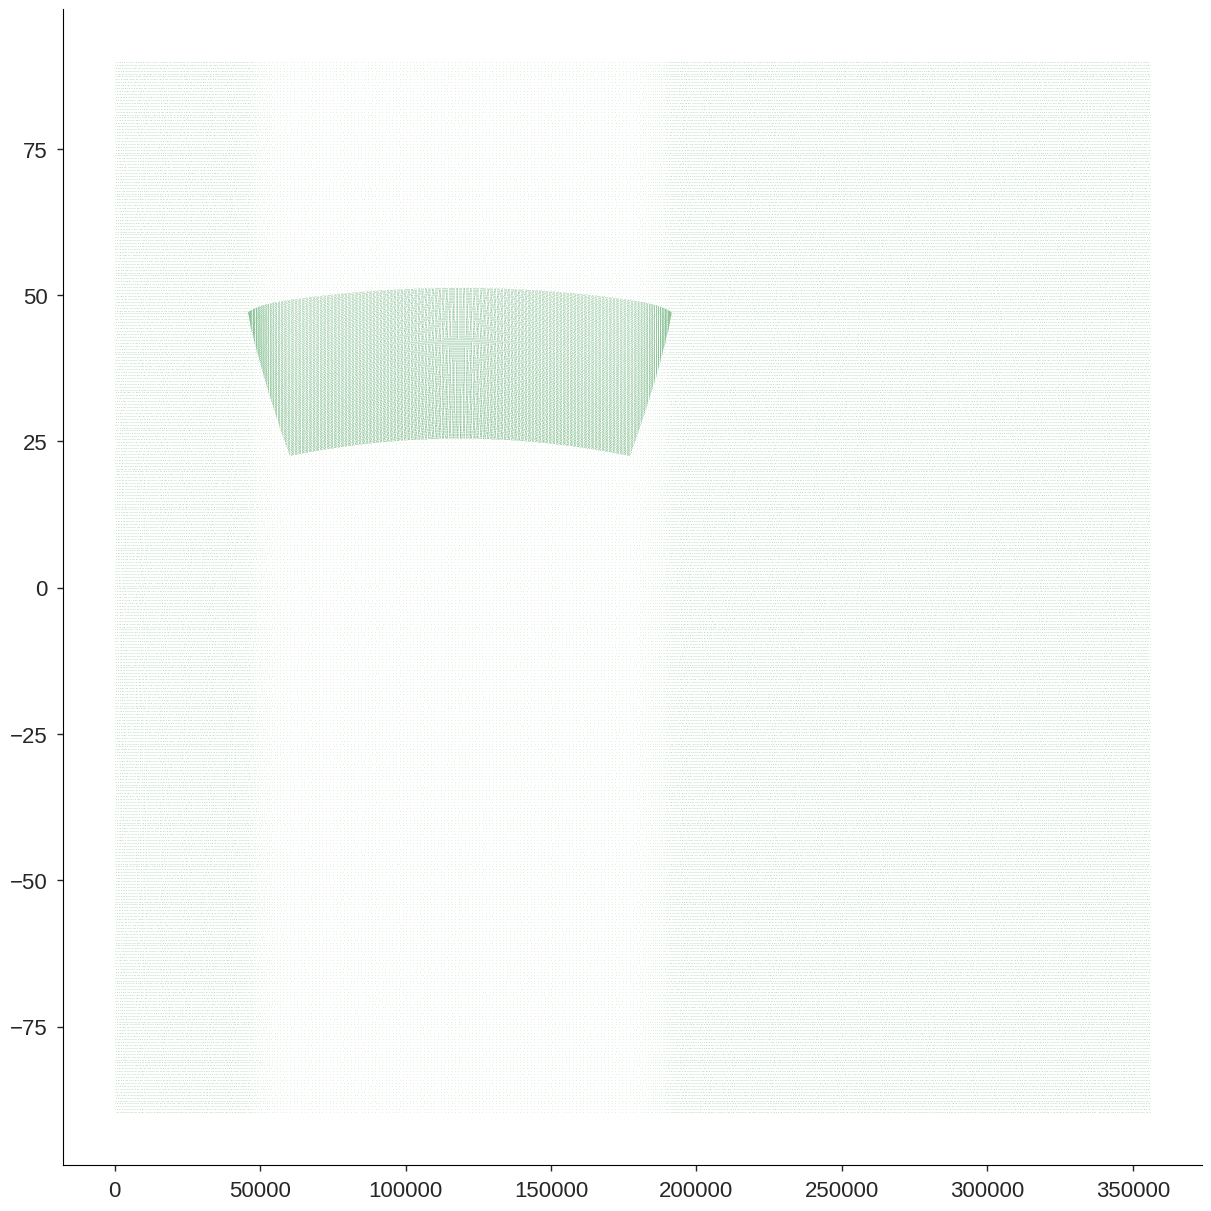

In [38]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(cds.lat.values, ls="", marker=".", markersize=.5)

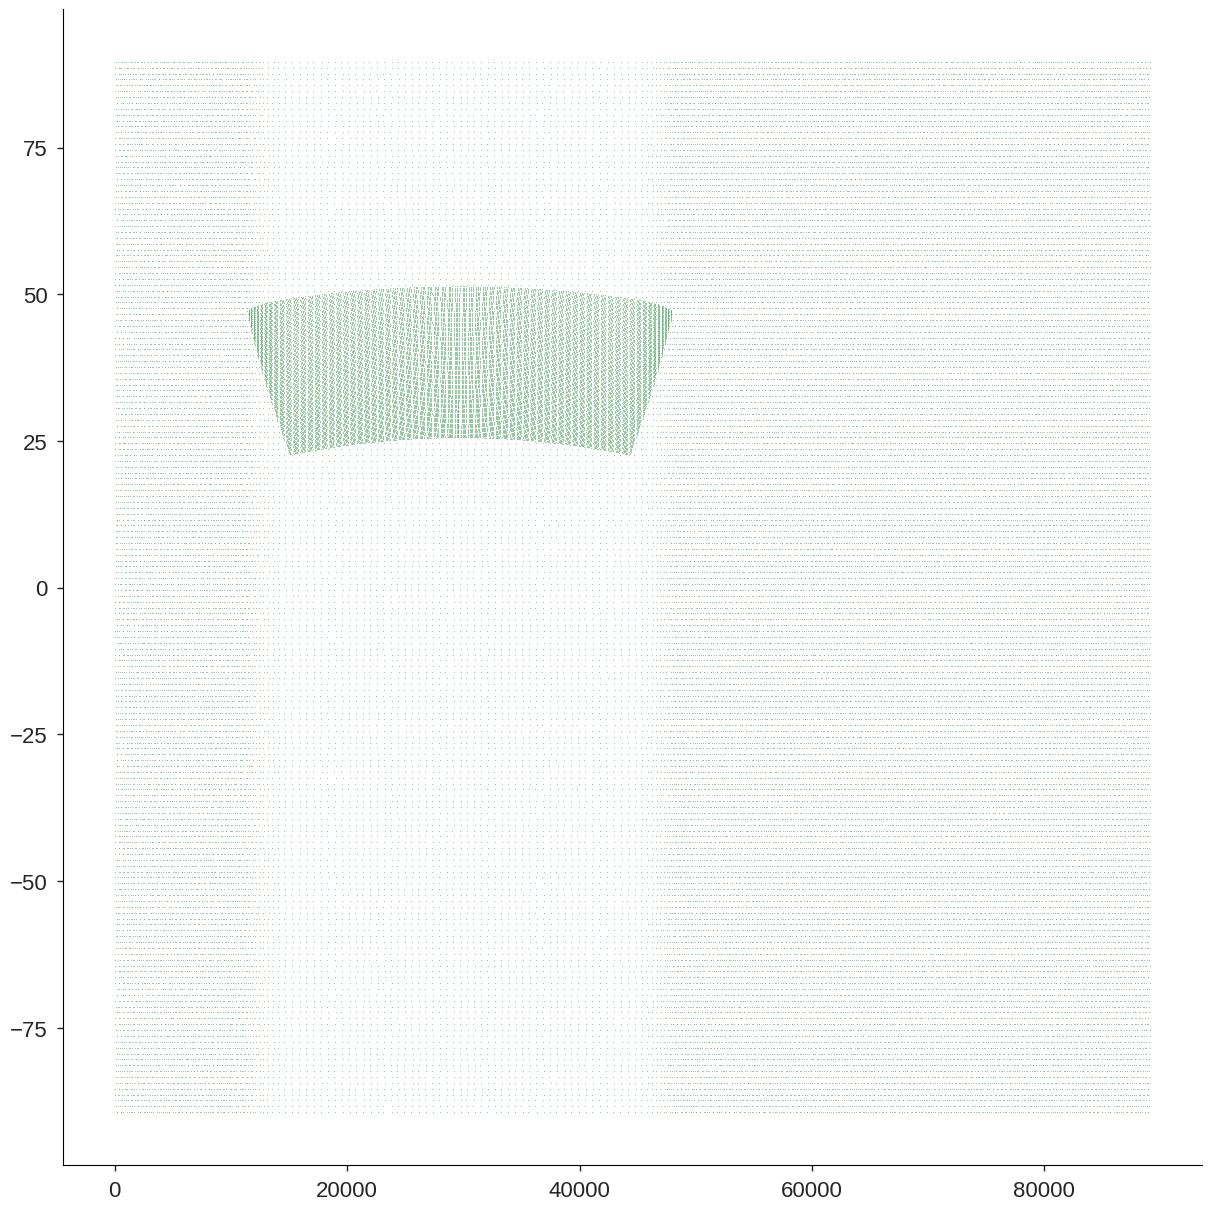

In [40]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(cds2.lat.values, ls="", marker=".", markersize=1)

In [43]:
np.savez("latentx2.stage1.spongex1.combined.sorted.npz", lon=cds.lon.values, lat=cds.lat.values)
np.savez("latentx4.stage2.spongex1.combined.sorted.npz", lon=cds2.lon.values, lat=cds2.lat.values)

In [44]:
checkit = np.load("latentx2.stage1.spongex1.combined.sorted.npz")
checkit2 = np.load("latentx4.stage2.spongex1.combined.sorted.npz")

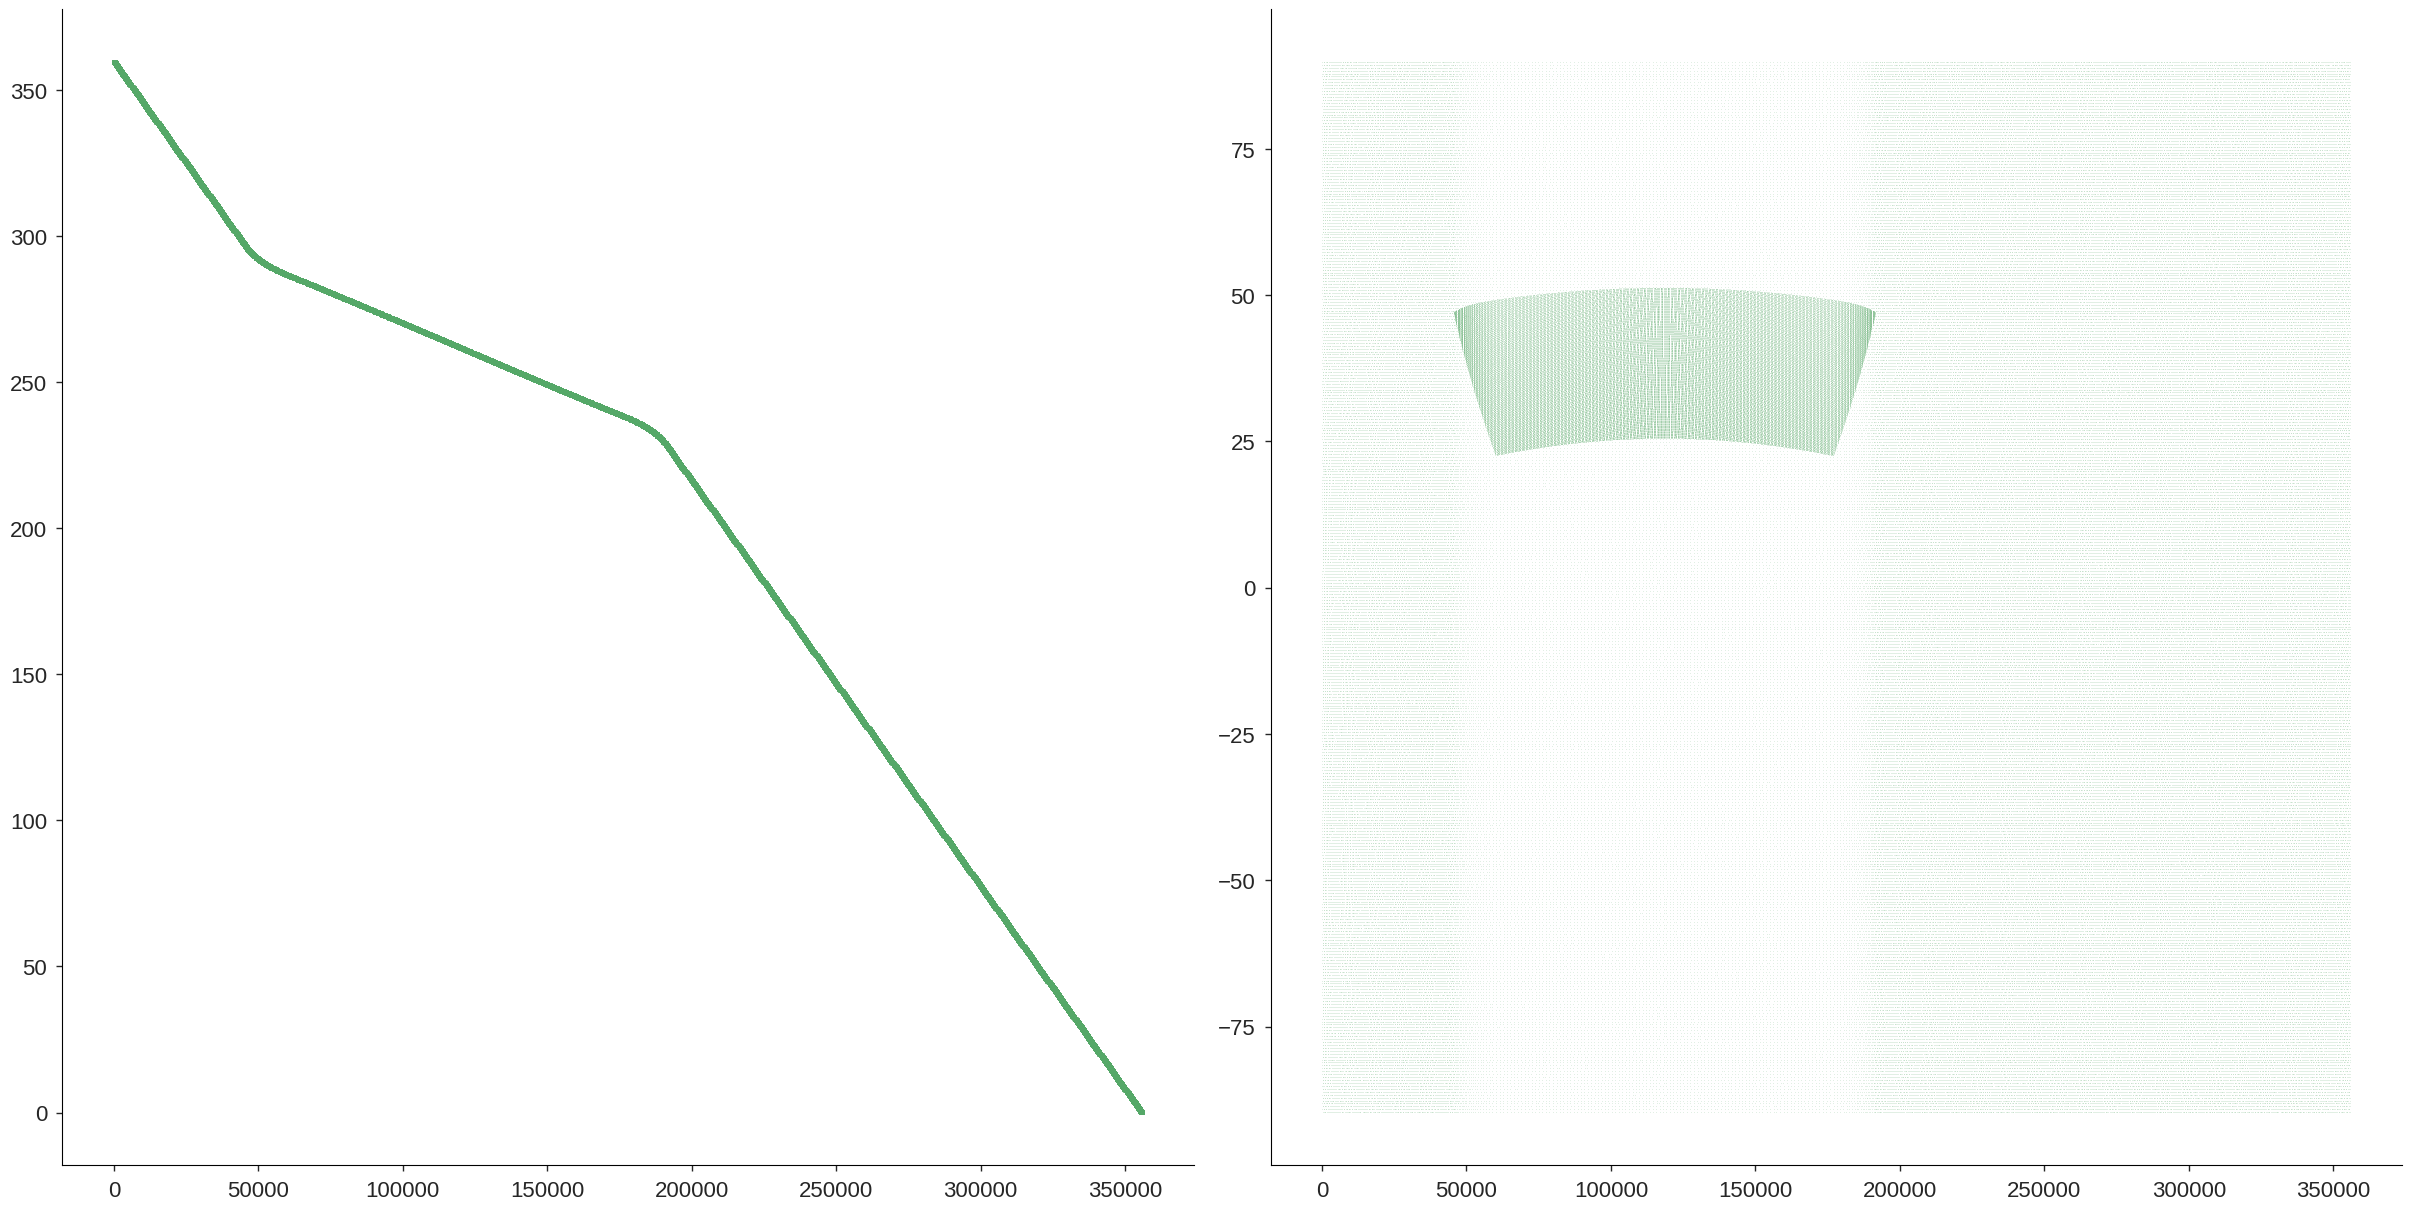

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(24, 12), constrained_layout=True)
axs[0].plot(checkit["lon"], ls="", marker=".")
axs[1].plot(checkit["lat"], ls="", marker=".",markersize=.5)

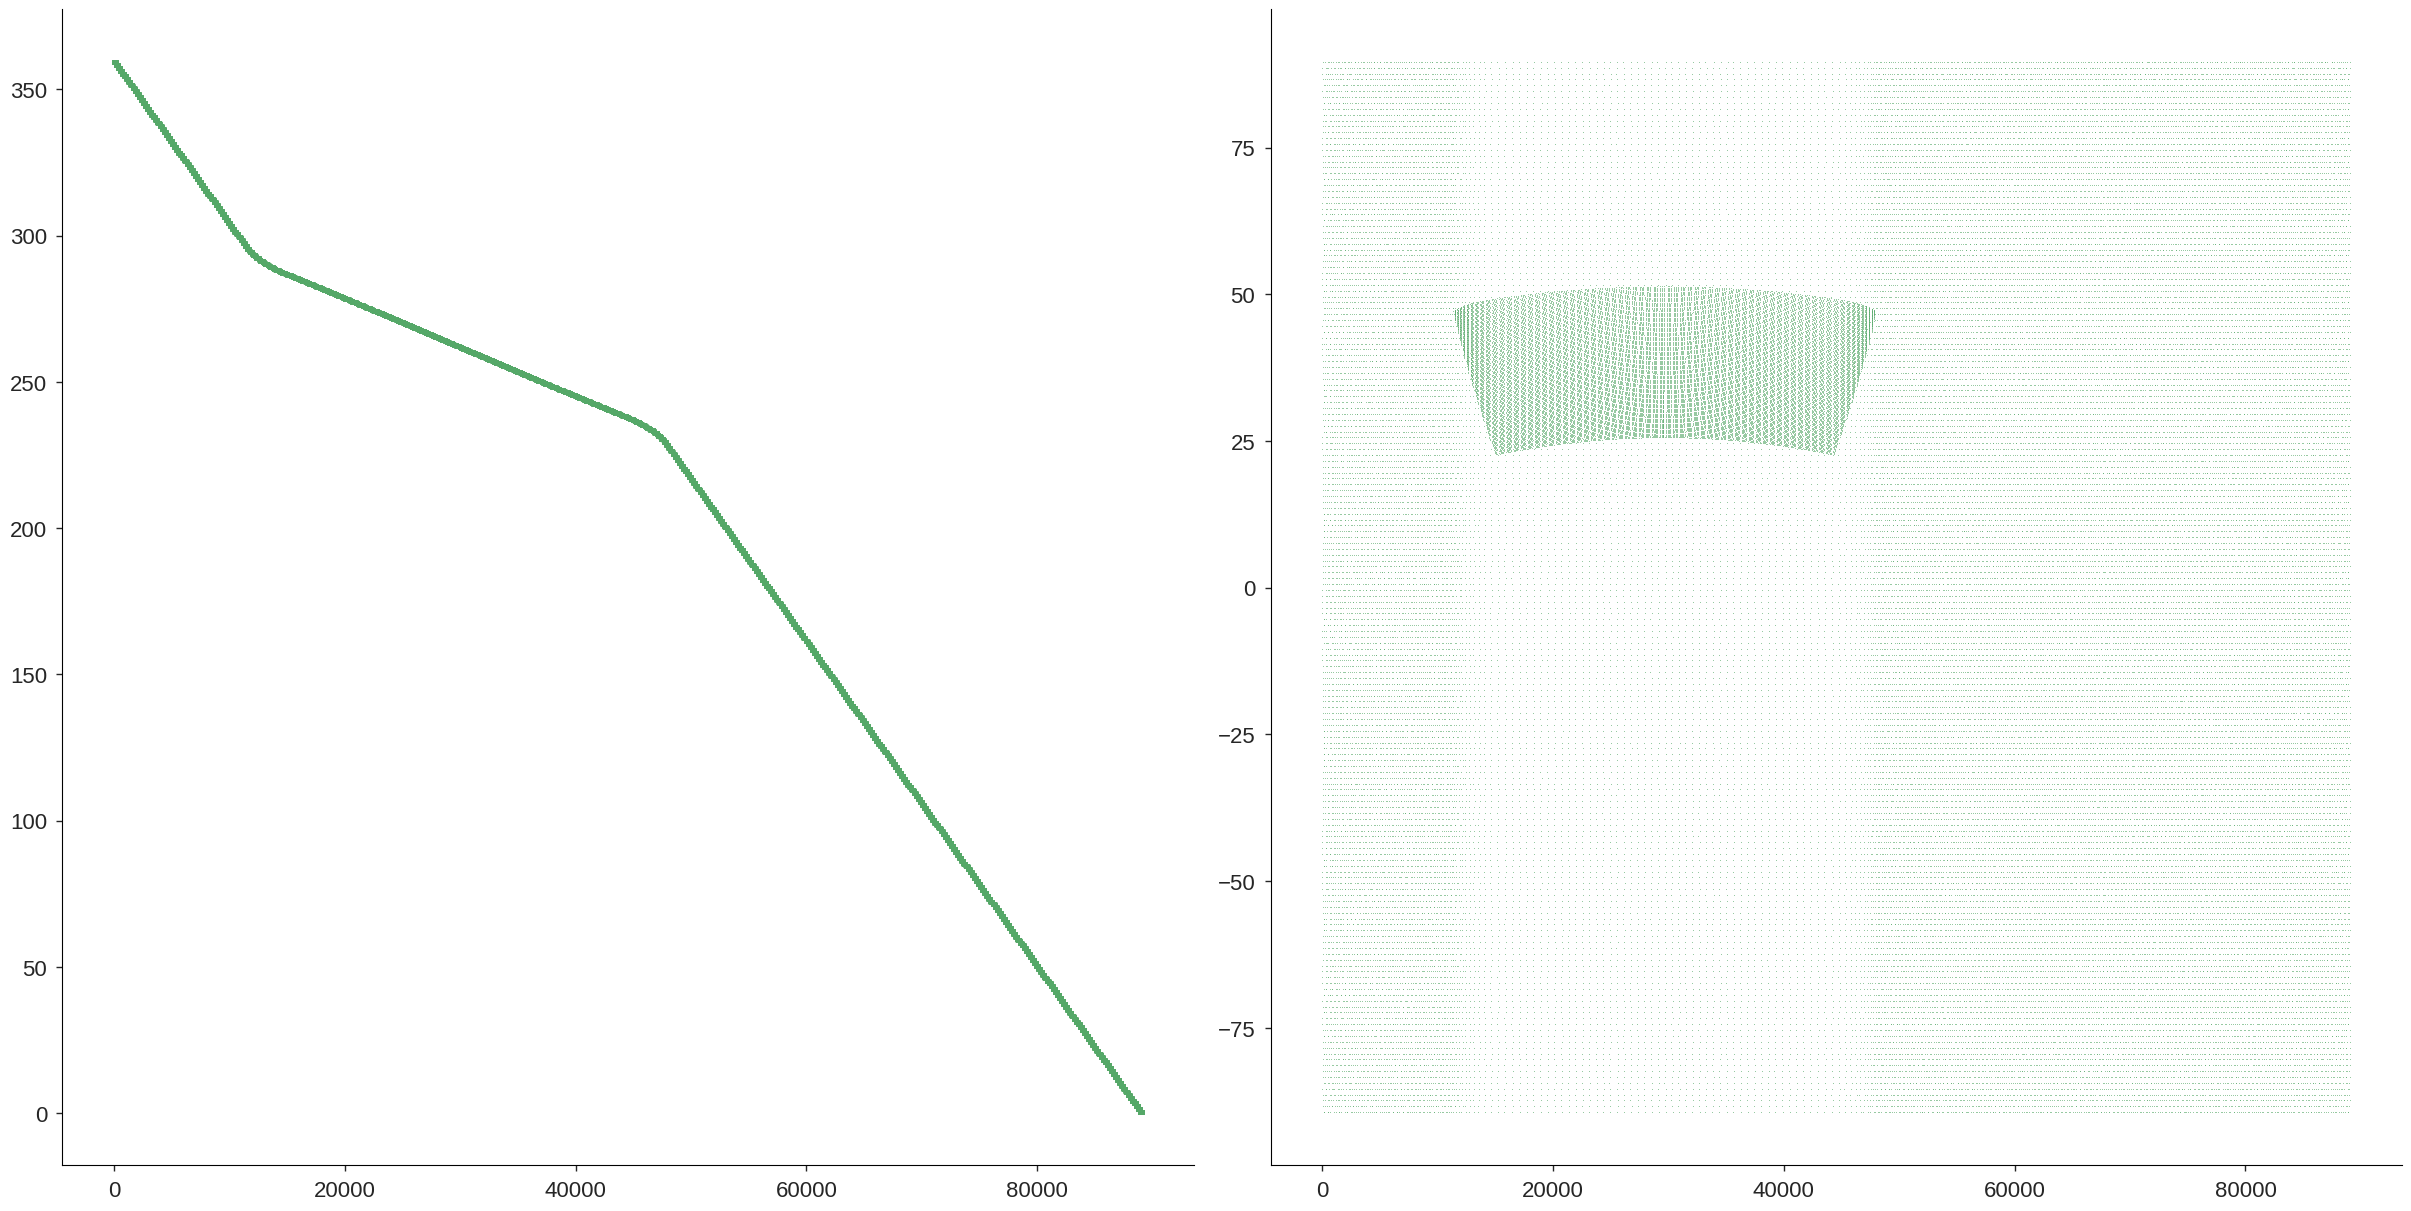

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(24, 12), constrained_layout=True)
axs[0].plot(checkit2["lon"], ls="", marker=".")
axs[1].plot(checkit2["lat"], ls="", marker=".",markersize=1)